# Dat550 Project

In [34]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalMaxPool1D, Embedding, TextVectorization, MaxPooling1D, LSTM, Dropout, GlobalMaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


## Data Loading Functions

In [8]:
# Load articles
def load_articles(filepath):
    articles = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            text = data["title"] + " " + data["content"]
            articles.append({
                "id": data["id"],
                "text": text
            })
    return articles

# Load labels
def load_labels(filepath):
    labels = []
    with open(filepath, "r", encoding="UTF-8") as f:
        for line in f:
            data = json.loads(line)
            labels.append({
                "id": str(data["id"]).zfill(7),  # Zero-pad to match article IDs
                "label": 1 if data["hyperpartisan"] else 0
            })
    return labels

## File paths

In [9]:
# df = pd.read_xml("Webis-data/extracted/ground-truth-training-byarticle-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-byarticle.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-training-bypublisher-20181122.xml")
# df.to_json("preprocessing/data/ground-truth-training-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-bypublisher-20181212.xml")
# df.to_json("preprocessing/data/ground-truth-test-bypublisher.jsonl",orient="records",lines=True)

# df = pd.read_xml("Webis-data/extracted/ground-truth-test-byarticle-20181207.xml")
# df.to_json("preprocessing/data/ground-truth-test-byarticle.jsonl",orient="records",lines=True)

In [10]:
train_articles_path = "preprocessing/data/articles-training-byarticle.jsonl"
train_labels_path = "preprocessing/data/ground-truth-training-byarticle.jsonl"
test_articles_path  = "preprocessing/data/articles-test-byarticle.jsonl"
test_labels_path    = "preprocessing/data/ground-truth-test-byarticle.jsonl"

## Load and Merge Training Data

In [11]:
train_articles_df = pd.DataFrame(load_articles(train_articles_path))
train_labels_df   = pd.DataFrame(load_labels(train_labels_path))
train_articles_df["id"] = train_articles_df["id"].astype(str)
# Merge training data on 'id'
train_df = pd.merge(train_articles_df, train_labels_df, on="id")
# For training, we only need the text and the label

# Add publication data and such for more feature?

texts_train = train_df["text"].tolist()
labels_train = train_df["label"].values

print("Training data samples:", len(texts_train))

Training data samples: 645


## Load and Merge Test Data

In [12]:
test_articles_df = pd.DataFrame(load_articles(test_articles_path))
test_labels_df   = pd.DataFrame(load_labels(test_labels_path))
test_articles_df["id"] = test_articles_df["id"].astype(str)
# Merge test data on 'id'
test_df = pd.merge(test_articles_df, test_labels_df, on="id")
texts_test = test_df["text"].tolist()
labels_test = test_df["label"].values

print("Test data samples:", len(texts_test))

Test data samples: 628


## Preprocessing the Text with TextVectorization

In [28]:
max_tokens = 10000          # Maximum vocabulary size
max_sequence_length = 200   # Maximum sequence length (adjust as needed)

vectorize_layer = TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(texts_train)

# Vectorize the texts. The output is a tensor of shape (num_samples, max_sequence_length)
X_train = vectorize_layer(texts_train)
X_test  = vectorize_layer(texts_test)

print("X_train shape:", X_train.shape[1:])
print("X_test shape:", X_test.shape)

X_train shape: (200,)
X_test shape: (628, 200)


## Build the Convolutional Neural Network (CNN) Model 

In [35]:
model = Sequential([
    Input(shape=(max_sequence_length,)),
    # Embedding layer maps integer sequences to dense vectors.
    Embedding(input_dim=max_tokens, output_dim=128),
    Conv1D(filters=100, kernel_size=3, activation='relu'),
    GlobalMaxPool1D(),
    # Fully connect the network
    Dropout(0.5),
    Dense(units=64, activation='relu'),
    # Output layer
    Dropout(0.5),
    Dense(units=1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 198, 100)       │        38,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 100)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,325,029 (5.05 MB)

 Trainable params: 1,325,029 (5.05 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [15]:
history = model.fit(X_train, labels_train, batch_size=16, epochs=10, validation_split=0.2)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5403 - loss: 0.6894 - val_accuracy: 0.7209 - val_loss: 0.6110
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6179 - loss: 0.6273 - val_accuracy: 0.7209 - val_loss: 0.6204
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9096 - loss: 0.5314 - val_accuracy: 0.7287 - val_loss: 0.6042
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9758 - loss: 0.3114 - val_accuracy: 0.7054 - val_loss: 0.5719
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0800 - val_accuracy: 0.6822 - val_loss: 0.5447
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.7209 - val_loss: 0.5570
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0064 - val_accuracy: 0.6899 - val_loss: 0.5633
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.6899 - va

## Evaluate & Predict on Test Data

Final Evaluation - Loss: 0.6520, Accuracy: 0.6481
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


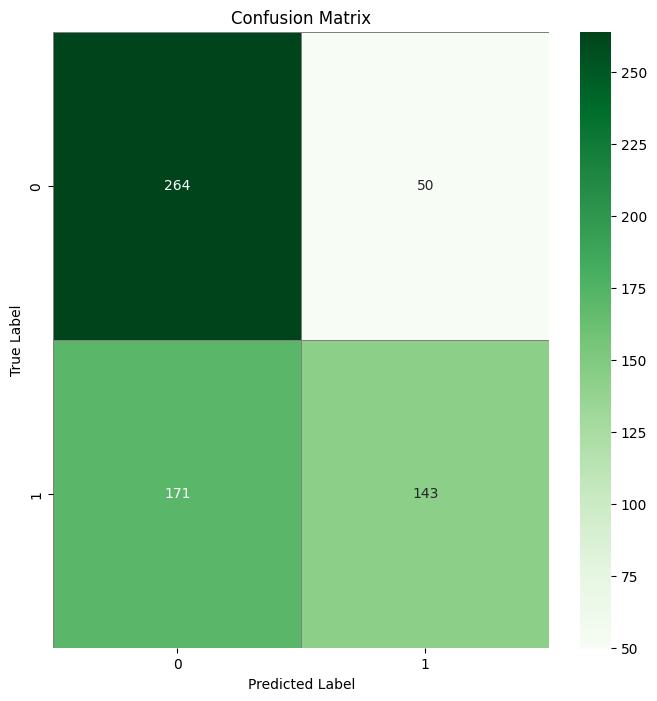

In [16]:
# Evaluate the model on test data and print loss and accuracy:
loss_eval, acc_eval = model.evaluate(X_test, labels_test, verbose=0)
print(f"Final Evaluation - Loss: {loss_eval:.4f}, Accuracy: {acc_eval:.4f}")

# Generate predictions: convert probabilities to 0 or 1 by thresholding at 0.5
predictions = model.predict(X_test)
pred_y = (predictions >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Hypermeter tuning

In [17]:
# 1. Define your hypermodel
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(max_sequence_length,)))
    
    # Tune embedding output dim
    model.add(Embedding(input_dim=max_tokens, output_dim=hp.Choice('embedding_dim', [64, 128, 256])))

    # Tune Conv1D
    model.add(Conv1D(
        filters=hp.Choice('filters', [64, 100, 128]),
        kernel_size=hp.Choice('kernel_size', [3, 5, 7]),
        activation='relu'
    ))
    
    model.add(GlobalMaxPool1D())

    # Optional dropout
    model.add(Dropout(hp.Float('dropout_rate', 0.0, 0.5, step=0.1)))

    # Tune dense units
    model.add(Dense(
        units=hp.Choice('dense_units', [32, 64, 128]),
        activation='relu'
    ))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Tune learning rate
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [18]:
# 2. Set up the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Try up to 20 different combinations
    executions_per_trial=1,
    directory='tuner_results',
    project_name='cnn_hyperparameter_tuning'
)

# 3. Start search
tuner.search(X_train, labels_train, epochs=10, validation_split=0.2, batch_size=16)

# 4. Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

# 5. Summary of best model
print("\nBest Hyperparameters:")
for param in best_hyperparams.values:
    print(f"{param}: {best_hyperparams.get(param)}")

Trial 20 Complete [00h 00m 07s]
val_accuracy: 0.7209302186965942

Best val_accuracy So Far: 0.7674418687820435
Total elapsed time: 00h 01m 49s


d:\Nedlastninger\school\DAT550-Project-1\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 16 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 196, 64)        │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)


Best Hyperparameters:
embedding_dim: 128
filters: 64
kernel_size: 5
dropout_rate: 0.0
dense_units: 128
learning_rate: 0.01


Final Evaluation - Loss: 0.6520, Accuracy: 0.6481
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


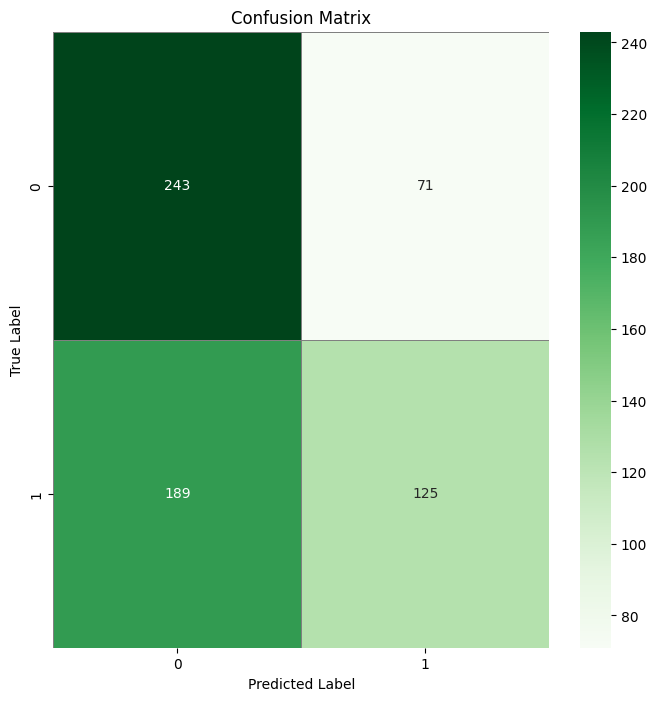

In [19]:
loss_eval_tuner, acc_eval_tuner = best_model.evaluate(X_test, labels_test, verbose=0)
print(f"Final Evaluation - Loss: {loss_eval:.4f}, Accuracy: {acc_eval:.4f}")

# Generate predictions: convert probabilities to 0 or 1 by thresholding at 0.5
predictions_tuner = best_model.predict(X_test)
pred_y_tuner = (predictions_tuner >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_tuner)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## LSTM CNN

In [20]:
def build_cnn_lstm_model():
    input_text = Input(shape=(max_sequence_length,))
    embedding = Embedding(input_dim=max_tokens, output_dim=256)(input_text)
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=2)(conv)
    lstm = LSTM(units=64, return_sequences=False)(pool)
    dropout = Dropout(rate=0.4)(lstm)
    dense = Dense(64, activation='relu')(dropout)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=input_text, outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

cnn_lstm_model = build_cnn_lstm_model()
cnn_lstm_model.summary()

# Train
cnn_lstm_model.fit(X_train, labels_train, epochs=10, batch_size=16, validation_split=0.2)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 256)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 198, 128)       │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 99, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,712,065 (10.35 MB)

 Trainable params: 2,712,065 (10.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.6054 - loss: 0.6768 - val_accuracy: 0.7209 - val_loss: 0.6372
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6013 - loss: 0.6304 - val_accuracy: 0.7287 - val_loss: 0.6317
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9218 - loss: 0.2980 - val_accuracy: 0.5969 - val_loss: 1.0619
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9699 - loss: 0.1373 - val_accuracy: 0.7054 - val_loss: 1.0131
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9749 - loss: 0.0710 - val_accuracy: 0.5426 - val_loss: 2.0688
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9579 - loss: 0.1008 - val_accuracy: 0.7132 - val_loss: 1.1281
Epoch 7/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9727 - loss: 0.0759 - val_accuracy: 0.6434 - val_loss: 1.4856
Epoch 8/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9773 - loss: 0.0537 - val_accuracy: 0.6279 - v

Best Model - Loss: 2.3809, Accuracy: 0.5780
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


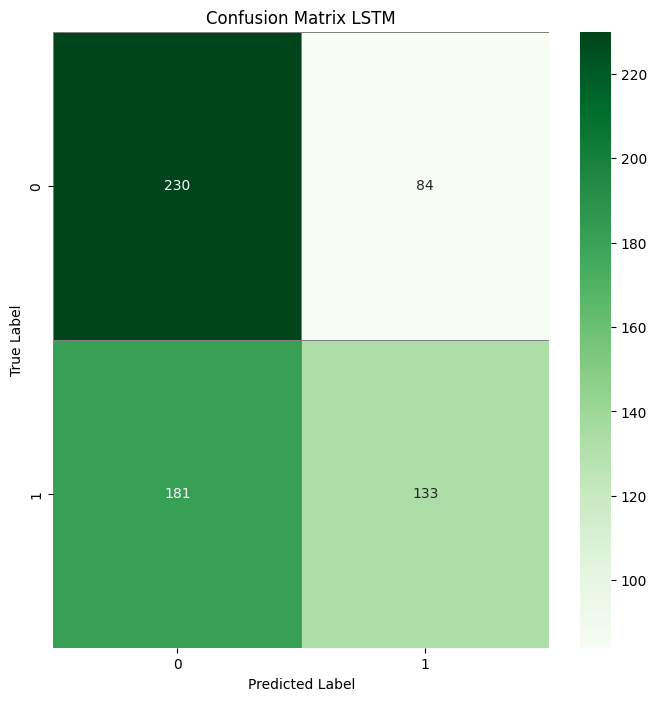

In [21]:
loss_eval_lstm, acc_eval_lstm = cnn_lstm_model.evaluate(X_test, labels_test, verbose=0)
print(f"Best Model - Loss: {loss_eval_lstm:.4f}, Accuracy: {acc_eval_lstm:.4f}")

predictions_lstm = cnn_lstm_model.predict(X_test)
pred_y_lstm = (predictions_lstm >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix LSTM")
plt.show()

## BERT CNN

In [22]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_bert(texts, max_len=256):
    return tokenizer(
        texts,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="tf"
    )

train_encodings = tokenize_bert(texts_train)
test_encodings = tokenize_bert(texts_test)

d:\Nedlastninger\school\DAT550-Project-1\.venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\willi\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [23]:
def build_bert_cnn_model():
    # Inputs
    input_ids = Input(shape=(256,), dtype=tf.int32, name="input_ids")
    attention_mask = Input(shape=(256,), dtype=tf.int32, name="attention_mask")

    # Load BERT
    bert_model = TFBertModel.from_pretrained("bert-base-uncased")

    # Get BERT embeddings using Keras Lambda layer
    def get_bert_embeddings(inputs):
        return bert_model(inputs)[0]

    bert_output = tf.keras.layers.Lambda(
    get_bert_embeddings,
    output_shape=(256, 768)
    )({
        "input_ids": input_ids,
        "attention_mask": attention_mask
    })

    bert_model.trainable = True 

    # CNN Layers
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(bert_output)
    pooled = GlobalMaxPooling1D()(conv)
    dense = Dense(64, activation='relu')(pooled)
    dropout = Dropout(0.4)(dense)
    output = Dense(1, activation='sigmoid')(dropout)

    # Build Model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [24]:
bert_cnn_model = build_bert_cnn_model()
bert_cnn_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train
bert_cnn_model.fit(
    x={"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y=labels_train,
    epochs=10,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop]
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256, 768)  │          0 │ attention_mask[0… │
│                     │                   │            │ input_ids[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 254, 128)  │    295,040 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ conv1d_2[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      8,256 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 303,361 (1.16 MB)

 Trainable params: 303,361 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5968 - loss: 0.8511 - val_accuracy: 0.8140 - val_loss: 0.4909
Epoch 2/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7981 - loss: 0.4506 - val_accuracy: 0.7752 - val_loss: 0.4413
Epoch 3/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8677 - loss: 0.3619 - val_accuracy: 0.8450 - val_loss: 0.3844
Epoch 4/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.9179 - loss: 0.2303 - val_accuracy: 0.8450 - val_loss: 0.3289
Epoch 5/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9820 - loss: 0.1094 - val_accuracy: 0.8372 - val_loss: 0.3548
Epoch 6/10
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9897 - loss: 0.0735 - val_accuracy: 0.8217 - val_loss: 0.3573


20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7973 - loss: 0.4517
Best Model - Loss: 0.4552, Accuracy: 0.7898
20/20 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step


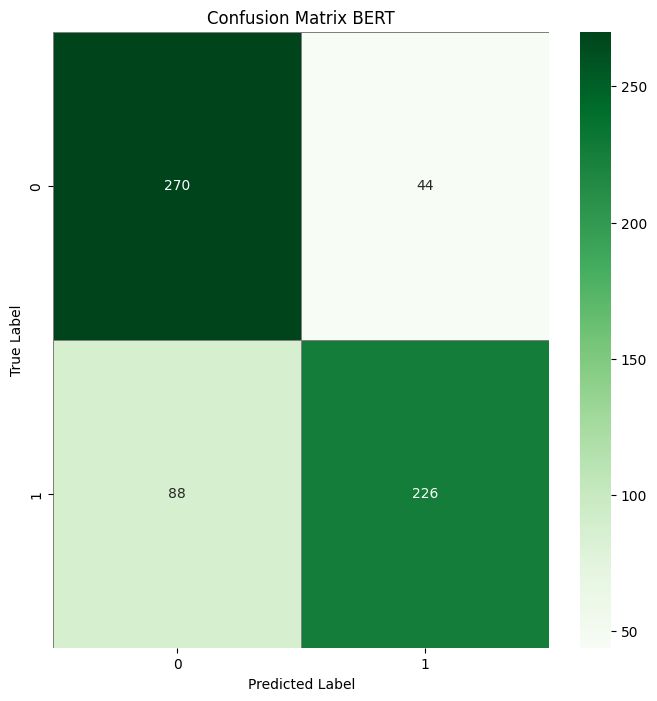

In [25]:
x_test = {
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
}

loss_eval_bert, acc_eval_bert = bert_cnn_model.evaluate(x=x_test, y=labels_test)
print(f"Best Model - Loss: {loss_eval_bert:.4f}, Accuracy: {acc_eval_bert:.4f}")

predictions_bert = bert_cnn_model.predict(x_test)
pred_y_bert = (predictions_bert >= 0.5).astype(int).flatten()

# Compute the confusion matrix
cm = confusion_matrix(labels_test, pred_y_bert)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Greens", fmt='d', linewidths=0.5, linecolor='gray')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix BERT")
plt.show()

In [26]:
print("CNN Report:\n", classification_report(labels_test, pred_y))
print("CNN-Tuner Report:\n", classification_report(labels_test, pred_y_tuner))
print("CNN-LSTM Report:\n", classification_report(labels_test, pred_y_lstm))
print("CNN-Bert Report:\n", classification_report(labels_test, pred_y_bert))

CNN Report:
               precision    recall  f1-score   support

           0       0.61      0.84      0.70       314
           1       0.74      0.46      0.56       314

    accuracy                           0.65       628
   macro avg       0.67      0.65      0.63       628
weighted avg       0.67      0.65      0.63       628

CNN-Tuner Report:
               precision    recall  f1-score   support

           0       0.56      0.77      0.65       314
           1       0.64      0.40      0.49       314

    accuracy                           0.59       628
   macro avg       0.60      0.59      0.57       628
weighted avg       0.60      0.59      0.57       628

CNN-LSTM Report:
               precision    recall  f1-score   support

           0       0.56      0.73      0.63       314
           1       0.61      0.42      0.50       314

    accuracy                           0.58       628
   macro avg       0.59      0.58      0.57       628
weighted avg       0.59 